In [244]:
# Standard Packages
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random
import time
import shutil
import warnings

# import cv2 as cv
# import s3fs?
# streaming data from camera to S3 bucket like HW3? 
# Use k8s?

# Deep Learning packages
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim # optimizers
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
import torchvision.models as models
import albumentations as A
# from albumentations.pytorch import ToTensorV2

warnings.filterwarnings('ignore')


In [3]:
# Change directory
os.chdir("./youtube_scraping/vid_to_image")

# **Useful Links**
[Basic segmentation](https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/) 

[Mask R-CNN](https://arxiv.org/abs/1703.06870)

[OpenCV GrabCut](https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html)

In [25]:
# import full convolutional network 
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

# import Deep Lab model 
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to C:\Users\JuanR/.cache\torch\hub\checkpoints\fcn_resnet101_coco-7ecb50ca.pth
100.0%


In [223]:
# Define the helper function
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = (image == l)
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        rgb = np.stack([r, g, b], axis=2)
    return rgb

In [211]:
def segment(net, path):
    img = Image.open(path)
    plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    # print(rgb)
    plt.imshow(rgb); plt.axis('off'); plt.show()
    return rgb

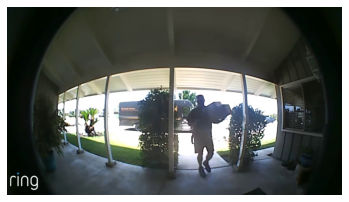

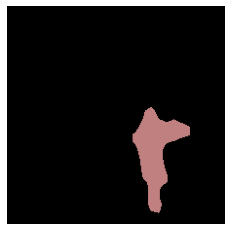

In [212]:
# DeepLab architecture segmentation of person. 
rgb = segment(dlab, "./image_21.jpg")

In [213]:
print(f'reshaped image: {rgb.shape}')

reshaped image: (224, 224, 3)


In [228]:
rgb[:,:,0]
rgb[:,:,1]
rgb[:,:,2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

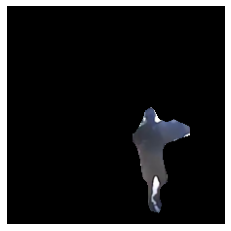

In [243]:
# Take crop from original image
img = Image.open("./image_21.jpg")
trf = T.Compose([T.Resize(256), 
                 T.CenterCrop(224), 
                 T.ToTensor()])
inp = trf(img).unsqueeze(0)

x,y,c = np.where(rgb != 0)
img_cropped = inp.cpu().detach().numpy().reshape(224, 224, 3)

# Use PIL resize to resize the image to 256 by 256 pixels from original size
# plt.imshow(img.resize((256,256)))

trf2 = T.Compose([T.Resize(256),
                 T.CenterCrop(224)])


resized = np.array(trf2(img))
new = np.zeros_like(resized).astype(np.uint8)
new[x,y] = resized[x,y]

plt.imshow(new); plt.axis('off'); plt.show()